In [1]:
!pip install ../../gentrain/.

Processing /Users/benkraling/code/thesis/gentrain
  Preparing metadata (setup.py) ... done
  Created wheel for gentrain: filename=gentrain-0.1.2-py3-none-any.whl size=26702 sha256=6ae8da16f3458dba987f80cb33b10d3c1633e50802cd870124533d3bef2505ee
  Stored in directory: /private/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/pip-ephem-wheel-cache-n9wr4mrg/wheels/cf/e4/57/91c03db2e8c043adeefe35dd0969d3049f61ae0218be0acc9f
Successfully built gentrain
  Attempting uninstall: gentrain
    Found existing installation: gentrain 0.1.2
    Uninstalling gentrain-0.1.2:
      Successfully uninstalled gentrain-0.1.2


In [2]:
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import pandas as pd
from gentrain.encoding import get_mutation_sensitive_encodings
from gentrain.candidate_sourcing import bitwise_xor_candidates, and_or_lsh, get_hnsw_candidates
from gentrain.graph import build_mst, export_graph_gexf, get_outbreak_community_labels, build_graph
from gentrain.evaluation import get_candidate_evaluation_and_export_mst
import os
import shutil

In [4]:
aggregate = "nrw_202203"
size = 10000

In [5]:
graph_path = f"graphs/{aggregate}/{size}"
if os.path.exists(f"graphs/{aggregate}/{size}") and os.path.isdir(f"graphs/{aggregate}/{size}"):
    shutil.rmtree(f"graphs/{aggregate}/{size}")
if not os.path.exists(f"graphs/{aggregate}"):
    os.mkdir(f"graphs/{aggregate}")
os.mkdir(f"graphs/{aggregate}/{size}")

In [6]:
sequences_df = pd.read_csv(f"../00_data_understanding_and_preparation/aggregates/{aggregate}/{size}/sequences_and_metadata.csv", delimiter=";").set_index("igs_id").sort_index()
sequences_count = len(sequences_df)
calculations_count = (sequences_count*(sequences_count-1))/2

In [7]:
distance_matrix_df = pd.read_csv(f"../01_algorithm_optimization/distance_matrices/{aggregate}/{size}/distance_matrix.csv", delimiter=";",
                                     index_col="Unnamed: 0").sort_index()
distance_matrix_df = distance_matrix_df[~distance_matrix_df.index.duplicated(keep='first')]
distance_matrix_df = distance_matrix_df.loc[sequences_df.index, sequences_df.index]
distance_matrix = distance_matrix_df.to_numpy()

In [8]:
gentrain_graph = build_graph(distance_matrix)
gentrain_mst = build_mst(gentrain_graph)

mst generation time: 1488.96s


In [9]:
gentrain_community_labels = get_outbreak_community_labels(gentrain_mst)
datetime_sampling_dates = pd.to_datetime(sequences_df["date_of_sampling"])
numeric_dates = (datetime_sampling_dates - datetime_sampling_dates.min()).dt.days
export_graph_gexf(gentrain_mst, gentrain_community_labels, sequences_df, f"{graph_path}/gentrain")

In [10]:
encodings = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=True, filter_N=True)
encodings_length = len(encodings[0])

execution time: 107.13s


In [11]:
encodings_length

3776

In [12]:
accurate_evaluation = {}
for calculation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    accurate_candidates, runtime = bitwise_xor_candidates(encodings, int(calculation_rate * calculations_count), "depth")
    accurate_evaluation[calculation_rate] = get_candidate_evaluation_and_export_mst(f"accurate_candidates_{calculation_rate}", accurate_candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime)

execution time xor distance calculation: 269.96s
execution time depth search: 180.68s
execution time 49995: 458.1s
mst generation time: 0.08s
execution time xor distance calculation: 271.13s
execution time depth search: 198.05s
execution time 499950: 477.67s
mst generation time: 1.0s
execution time xor distance calculation: 272.66s
execution time depth search: 199.45s
execution time 999900: 486.83s
mst generation time: 68.17s
execution time xor distance calculation: 278.51s
execution time depth search: 209.42s
execution time 1499850: 498.48s
mst generation time: 66.46s
execution time xor distance calculation: 277.75s
execution time depth search: 213.63s
execution time 1999800: 500.03s
mst generation time: 75.8s
execution time xor distance calculation: 279.64s
execution time depth search: 213.41s
execution time 2499750: 502.96s
mst generation time: 89.65s
execution time xor distance calculation: 280.52s
execution time depth search: 214.65s
execution time 2999700: 506.84s
mst generation 

In [13]:
approximate_evaluation = {}
for hash_length in [2000, 2500, 3000]:
    approximate_evaluation[hash_length] = {}
    for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        print(hash_length, iterations)
        approximate_lsh_candidates = and_or_lsh(encodings, hash_length, iterations)
        approximate_evaluation[hash_length][iterations] = get_candidate_evaluation_and_export_mst(f"approximate_candates_{hash_length}_{iterations}", approximate_lsh_candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]),sequences_df, 0)

2000 1
xor lsh execution time: 1.6
mst generation time: 47.5s
2000 2
xor lsh execution time: 2.99
mst generation time: 67.18s
2000 4
xor lsh execution time: 5.8
mst generation time: 83.04s
2000 8
xor lsh execution time: 21.92
mst generation time: 116.54s
2000 16
xor lsh execution time: 23.56
mst generation time: 159.4s
2000 32
xor lsh execution time: 46.79
mst generation time: 204.92s
2000 64
xor lsh execution time: 95.58
mst generation time: 212.86s
2000 128
xor lsh execution time: 189.35
mst generation time: 315.79s
2000 256
xor lsh execution time: 447.19
mst generation time: 416.57s
2500 1
xor lsh execution time: 1.93
mst generation time: 0.39s
2500 2
xor lsh execution time: 3.56
mst generation time: 47.19s
2500 4
xor lsh execution time: 16.52
mst generation time: 46.09s
2500 8
xor lsh execution time: 23.98
mst generation time: 69.47s
2500 16
xor lsh execution time: 40.49
mst generation time: 92.16s
2500 32
xor lsh execution time: 74.8
mst generation time: 118.94s
2500 64
xor lsh ex

In [14]:
hnsw_evaluation = {}
for calculation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,  0.08, 0.09, 0.1, 0.15]:
    hnsw_candidates, runtime = get_hnsw_candidates(encodings, int(calculation_rate * calculations_count))
    hnsw_evaluation[calculation_rate] = get_candidate_evaluation_and_export_mst(f"hnsw_candidates_{calculation_rate}", hnsw_candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime)

execution time 49995: 11.63s
mst generation time: 0.05s
execution time 499950: 11.54s
mst generation time: 18.71s
execution time 999900: 12.23s
mst generation time: 36.73s
execution time 1499850: 13.62s
mst generation time: 46.41s
execution time 1999800: 14.46s
mst generation time: 64.31s
execution time 2499750: 15.14s
mst generation time: 81.75s
execution time 2999700: 16.44s
mst generation time: 76.67s
execution time 3499650: 17.61s
mst generation time: 78.3s
execution time 3999600: 17.97s
mst generation time: 81.73s
execution time 4499550: 18.0s
mst generation time: 102.66s
execution time 4999500: 21.21s
mst generation time: 105.95s
execution time 7499250: 25.23s
mst generation time: 127.41s


In [25]:
pd.DataFrame(approximate_evaluation[2000]).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
1,0.017781,0.348474,1.0,1.0,0.348474,0.0,1.291975,-0.252519,13.0,4816.0,0.049036,0.994347,0.014847
2,0.026960,0.509350,1.0,1.0,0.509350,0.0,1.407121,-0.137373,13.0,3386.0,0.098077,0.987471,0.007971
4,0.024181,0.462393,1.0,1.0,0.462393,0.0,1.560606,0.016112,72.0,2278.0,0.121239,0.989275,0.009775
8,0.071142,0.750132,1.0,1.0,0.750132,0.0,1.637475,0.092980,21.0,1098.0,0.186197,0.988293,0.008793
16,0.113258,0.854812,1.0,1.0,0.854812,0.0,1.665044,0.120550,17.0,488.0,0.247816,0.985442,0.005942
32,0.176899,0.897477,1.0,1.0,0.897477,0.0,1.683034,0.138539,16.0,204.0,0.304042,0.985964,0.006464
64,0.262804,0.940250,1.0,1.0,0.940250,0.0,1.641812,0.097318,18.0,101.0,0.400108,0.984777,0.005277
128,0.322763,0.948334,1.0,1.0,0.948334,0.0,1.631487,0.086992,16.0,53.0,0.460629,0.983628,0.004128
256,0.398650,0.980470,1.0,1.0,0.980470,0.0,1.606269,0.061774,20.0,30.0,0.630588,0.986771,0.007271


In [26]:
pd.DataFrame(approximate_evaluation[2500]).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
1,0.005114,0.224185,1.0,1.0,0.224185,0.0,0.999768,-0.544726,11.0,6118.0,0.028385,0.995880,0.016380
2,0.012762,0.364008,1.0,1.0,0.364008,0.0,1.189924,-0.354570,16.0,4730.0,0.043489,0.990866,0.011366
4,0.014187,0.405680,1.0,1.0,0.405680,0.0,1.346673,-0.197822,13.0,3613.0,0.076801,0.996050,0.016550
8,0.026064,0.639946,1.0,1.0,0.639946,0.0,1.460010,-0.084484,15.0,2148.0,0.117833,0.992640,0.013140
16,0.050179,0.740709,1.0,1.0,0.740709,0.0,1.525356,-0.019138,13.0,1442.0,0.162684,0.987517,0.008017
32,0.062529,0.773734,1.0,1.0,0.773734,0.0,1.615901,0.071406,13.0,862.0,0.178468,0.989565,0.010065
64,0.104742,0.875552,1.0,1.0,0.875552,0.0,1.629382,0.084887,72.0,443.0,0.240045,0.986931,0.007431
128,0.141468,0.889188,1.0,1.0,0.889188,0.0,1.660138,0.115643,19.0,279.0,0.275205,0.985266,0.005766
256,0.201947,0.930067,1.0,1.0,0.930067,0.0,1.649116,0.104622,19.0,156.0,0.375207,0.985816,0.006316


In [27]:
pd.DataFrame(approximate_evaluation[3000]).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
1,0.001662,0.136716,1.0,1.0,0.136716,0.0,0.801462,-0.743032,10.0,6786.0,0.024114,0.998319,0.018819
2,0.003606,0.197079,1.0,1.0,0.197079,0.0,1.029213,-0.515282,12.0,5923.0,0.031932,0.997820,0.018320
4,0.005058,0.298422,1.0,1.0,0.298422,0.0,1.051084,-0.493410,13.0,5159.0,0.055344,0.994392,0.014892
8,0.010460,0.362135,1.0,1.0,0.362135,0.0,1.229753,-0.314741,12.0,4041.0,0.061274,0.994753,0.015253
16,0.010982,0.463102,1.0,1.0,0.463102,0.0,1.300287,-0.244207,11.0,3038.0,0.093615,0.991819,0.012319
32,0.031334,0.661767,1.0,1.0,0.661767,0.0,1.421696,-0.122798,13.0,2017.0,0.124110,0.993161,0.013661
64,0.037774,0.716624,1.0,1.0,0.716624,0.0,1.492297,-0.052198,12.0,1523.0,0.144277,0.992779,0.013279
128,0.052092,0.736559,1.0,1.0,0.736559,0.0,1.555181,0.010686,19.0,1044.0,0.170792,0.988841,0.009341
256,0.071179,0.837806,1.0,1.0,0.837806,0.0,1.586442,0.041948,20.0,736.0,0.210665,0.988184,0.008684


In [28]:
pd.DataFrame(hnsw_evaluation).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
0.001,0.000427,0.017520,1.0,1.0,0.017520,11.63,2.837815,1.293320,39.0,1416.0,0.055295,0.985849,0.006349
0.010,0.005854,0.137884,1.0,1.0,0.137884,11.54,2.287707,0.743213,37.0,173.0,0.092481,0.988604,0.009104
0.020,0.011403,0.234379,1.0,1.0,0.234379,12.23,2.166306,0.621812,37.0,13.0,0.109646,0.987385,0.007885
0.030,0.015236,0.315349,1.0,1.0,0.315349,13.62,2.002592,0.458098,37.0,9.0,0.099795,0.983787,0.004287
0.040,0.020579,0.373840,1.0,1.0,0.373840,14.46,1.926531,0.382036,37.0,4.0,0.104780,0.984895,0.005395
0.050,0.025281,0.414414,1.0,1.0,0.414414,15.14,1.893029,0.348535,37.0,1.0,0.111256,0.981600,0.002100
0.060,0.030447,0.452478,1.0,1.0,0.452478,16.44,1.864036,0.319542,37.0,1.0,0.129143,0.984100,0.004600
0.070,0.034845,0.479533,1.0,1.0,0.479533,17.61,1.847235,0.302740,37.0,1.0,0.131169,0.983400,0.003900
0.080,0.040639,0.527137,1.0,1.0,0.527137,17.97,1.831133,0.286639,37.0,1.0,0.131323,0.983400,0.003900
0.090,0.046275,0.561546,1.0,1.0,0.561546,18.00,1.811561,0.267067,37.0,1.0,0.138290,0.983800,0.004300


## Evaluation

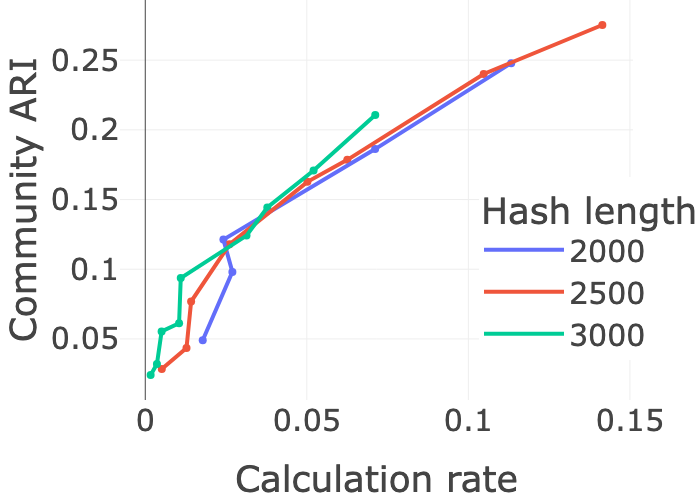

In [17]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = {}
ari = {}

for index, hash_length in enumerate([2000, 2500, 3000]):
    computation_rates[hash_length] = []
    ari[hash_length] = []
    for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        if approximate_evaluation[hash_length][iterations]["computation_rate"] <= 0.15:
            computation_rates[hash_length].append(approximate_evaluation[hash_length][iterations]["computation_rate"])
            ari[hash_length].append(approximate_evaluation[hash_length][iterations]["adjusted_rand_index"])
            fig.add_trace(go.Scatter(
                x=[approximate_evaluation[hash_length][iterations]["computation_rate"]],
                y=[approximate_evaluation[hash_length][iterations]["adjusted_rand_index"]],
                mode='markers',
                showlegend=False,
                marker=dict(color=pc.qualitative.Plotly[index], size=8),
            ))

for index, hash_length in enumerate([2000, 2500, 3000]):
    fig.add_trace(go.Scatter(
        x=computation_rates[hash_length],
        y=ari[hash_length],
        mode='lines',
        name=hash_length,
        line=dict(color=pc.qualitative.Plotly[index], width=4, dash="solid"),
    ))

fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Community ARI',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="Hash length",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
      legend=dict(
        itemwidth=80,
        x=0.7,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_hash_lengths_ari_nrw_2022.svg", width=1000, height=800)

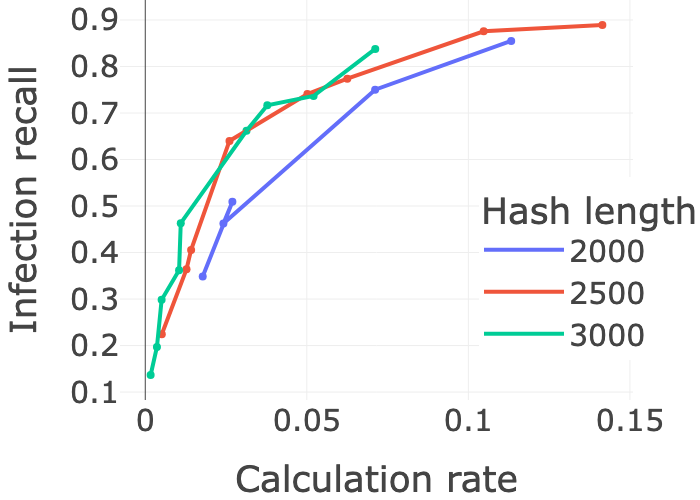

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = {}
infection_detection_rates = {}

for index, hash_length in enumerate([2000, 2500, 3000]):
    computation_rates[hash_length] = []
    infection_detection_rates[hash_length] = []
    for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        if approximate_evaluation[hash_length][iterations]["computation_rate"] < 0.15:
            computation_rates[hash_length].append(approximate_evaluation[hash_length][iterations]["computation_rate"])
            infection_detection_rates[hash_length].append(approximate_evaluation[hash_length][iterations]["infection_detection_rate"])
            fig.add_trace(go.Scatter(
                x=[approximate_evaluation[hash_length][iterations]["computation_rate"]],
                y=[approximate_evaluation[hash_length][iterations]["infection_detection_rate"]],
                mode='markers',
                showlegend=False,
                marker=dict(color=pc.qualitative.Plotly[index], size=8),
            ))

for index, hash_length in enumerate([2000, 2500, 3000]):
    fig.add_trace(go.Scatter(
        x=computation_rates[hash_length],
        y=infection_detection_rates[hash_length],
        mode='lines',
        name=hash_length,
        line=dict(color=pc.qualitative.Plotly[index], width=4, dash="solid"),
    ))



fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Infection recall',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="Hash length",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
    legend=dict(
        itemwidth=80,
        x=0.7,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_hash_lengths_infection_recall_nrw_2022.svg", width=1000, height=800)

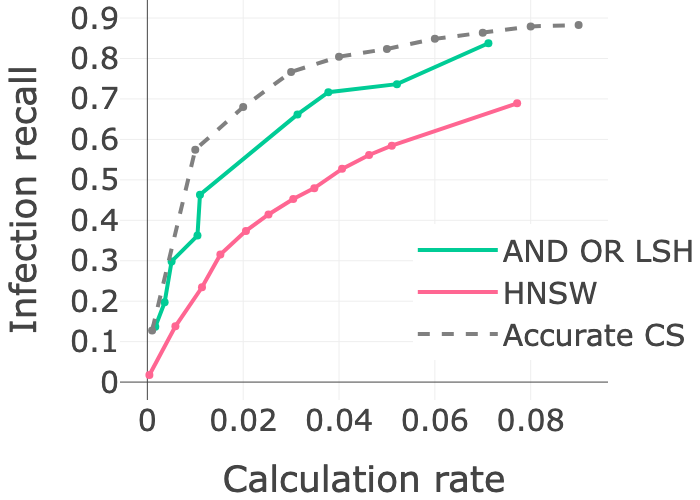

In [20]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = []
infection_detection_rates = []
for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    if approximate_evaluation[3000][iterations]["computation_rate"] < 0.15:
        computation_rates.append(approximate_evaluation[3000][iterations]["computation_rate"])
        infection_detection_rates.append(approximate_evaluation[3000][iterations]["infection_detection_rate"])
        fig.add_trace(go.Scatter(
            x=[approximate_evaluation[3000][iterations]["computation_rate"]],
            y=[approximate_evaluation[3000][iterations]["infection_detection_rate"]],
            mode='markers',
            showlegend=False,
            marker=dict(color=pc.qualitative.Plotly[2], size=8),
        ))

fig.add_trace(go.Scatter(
    x=computation_rates,
    y=infection_detection_rates,
    mode='lines',
    name="AND OR LSH",
    line=dict(color=pc.qualitative.Plotly[2], width=4, dash="solid"),
))

computation_rates_hnsw = []
ari_hnsw = []
for computation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15]:
    computation_rates_hnsw.append(hnsw_evaluation[computation_rate]["computation_rate"])
    ari_hnsw.append(hnsw_evaluation[computation_rate]["infection_detection_rate"])
    fig.add_trace(go.Scatter(
        x=[hnsw_evaluation[computation_rate]["computation_rate"]],
        y=[hnsw_evaluation[computation_rate]["infection_detection_rate"]],
        mode='markers',
        showlegend=False,
        marker=dict(color=pc.qualitative.Plotly[6], size=8),
    ))
    
fig.add_trace(go.Scatter(
    x=computation_rates_hnsw,
    y=ari_hnsw,
    mode='lines',
    name="HNSW",
    line=dict(color=pc.qualitative.Plotly[6], width=4, dash="solid"),
))

ari_accurate = []
for computation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    ari_accurate.append(accurate_evaluation[computation_rate]["infection_detection_rate"])
    fig.add_trace(go.Scatter(
        x=[computation_rate],
        y=[accurate_evaluation[computation_rate]["infection_detection_rate"]],
        mode='markers',
        showlegend=False,
        marker=dict(color="grey", size=8),
    ))

fig.add_trace(go.Scatter(
    x=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
    y=ari_accurate,
    mode='lines',
    name="Accurate CS",
    line=dict(color="grey", width=4, dash="dash"),
))


fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Infection recall',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
    legend=dict(
        itemwidth=80,
        x=0.6,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_comparison_infection_recall_nrw_2022.svg", width=1000, height=800)

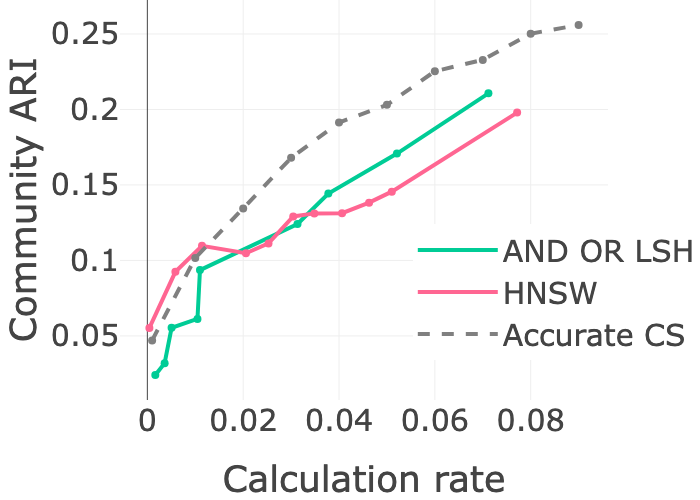

In [21]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = []
infection_detection_rates = []
for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    if approximate_evaluation[3000][iterations]["computation_rate"] < 0.15:
        computation_rates.append(approximate_evaluation[3000][iterations]["computation_rate"])
        infection_detection_rates.append(approximate_evaluation[3000][iterations]["adjusted_rand_index"])
        fig.add_trace(go.Scatter(
            x=[approximate_evaluation[3000][iterations]["computation_rate"]],
            y=[approximate_evaluation[3000][iterations]["adjusted_rand_index"]],
            mode='markers',
            showlegend=False,
            marker=dict(color=pc.qualitative.Plotly[2], size=8),
        ))

fig.add_trace(go.Scatter(
    x=computation_rates,
    y=infection_detection_rates,
    mode='lines',
    name="AND OR LSH",
    line=dict(color=pc.qualitative.Plotly[2], width=4, dash="solid"),
))

computation_rates_hnsw = []
ari_hnsw = []
for computation_rate in [0.001, 0.01, 0.02, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15]:
    computation_rates_hnsw.append(hnsw_evaluation[computation_rate]["computation_rate"])
    ari_hnsw.append(hnsw_evaluation[computation_rate]["adjusted_rand_index"])
    fig.add_trace(go.Scatter(
        x=[hnsw_evaluation[computation_rate]["computation_rate"]],
        y=[hnsw_evaluation[computation_rate]["adjusted_rand_index"]],
        mode='markers',
        showlegend=False,
        marker=dict(color=pc.qualitative.Plotly[6], size=8),
    ))
    
fig.add_trace(go.Scatter(
    x=computation_rates_hnsw,
    y=ari_hnsw,
    mode='lines',
    name="HNSW",
    line=dict(color=pc.qualitative.Plotly[6], width=4, dash="solid"),
))

ari_accurate = []
for computation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    ari_accurate.append(accurate_evaluation[computation_rate]["adjusted_rand_index"])
    fig.add_trace(go.Scatter(
        x=[computation_rate],
        y=[accurate_evaluation[computation_rate]["adjusted_rand_index"]],
        mode='markers',
        showlegend=False,
        marker=dict(color="grey", size=8),
    ))

fig.add_trace(go.Scatter(
    x=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
    y=ari_accurate,
    mode='lines',
    name="Accurate CS",
    line=dict(color="grey", width=4, dash="dash"),
))


fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Community ARI',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
    legend=dict(
        itemwidth=80,
        x=0.6,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_comparison_ari_nrw_2022.svg", width=1000, height=800)